In [1]:
import pandas as pd
import numpy as np

import gym
from gym import spaces
import gym_anytrading
from gym_anytrading.envs import TradingEnv, StocksEnv, Actions, Positions 
# from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt

In [2]:
from historical_preprocess import pricesFeatureExtraction

def difference(dataDf, period):
    return dataDf.sub(dataDf.shift(period))
    
def ewm(dataDf, halflife):
    return dataDf.ewm(halflife=halflife, ignore_na=False,
                      min_periods=0, adjust=True).mean()

def rsi(data, period):
    data_upside = data.sub(data.shift(1), fill_value=0)
    data_downside = data_upside.copy()
    data_downside[data_upside > 0] = 0
    data_upside[data_upside < 0] = 0
    avg_upside = data_upside.rolling(period).mean()
    avg_downside = - data_downside.rolling(period).mean()
    rsi = 100 - (100 * avg_downside / (avg_downside + avg_upside))
    rsi[avg_downside == 0] = 100
    rsi[(avg_downside == 0) & (avg_upside == 0)] = 0
    
    return rsi

def bollinger_band(df, col, period, no_of_std=2):

    #Calculate rolling mean and standard deviation using number of days set above
    rolling_mean = df[col].rolling(period).mean()
    rolling_std = df[col].rolling(period).std()

    #create two new DataFrame columns to hold values of upper and lower Bollinger bands
    df['Rolling Mean'] = rolling_mean
    df['Bollinger High'] = rolling_mean + (rolling_std * no_of_std)
    df['Bollinger Low'] = rolling_mean - (rolling_std * no_of_std)

    return df

# TODO: MACD
# exp1 = df.y.ewm(span=12, adjust=False).mean()
# exp2 = df.y.ewm(span=26, adjust=False).mean()
# macd = exp1-exp2
# exp3 = macd.ewm(span=9, adjust=False).mean()

def normalize(df, col, rolling_window):
    std = df[col].rolling(rolling_window).std()
    std[std == 0] = 1
    return (df[col] - df[col].rolling(rolling_window).mean()) / std

def pricesFeatureExtraction(df, rolling_window, price_col='Close', eps=1e-4):
    
    df[price_col+'_diff'] = difference(df[price_col], rolling_window)
    df[price_col+'_diff'] = normalize(df, price_col+'_diff', rolling_window)

    df[price_col+'_moving_average'] = ewm(df[price_col], rolling_window)
    df[price_col+'_moving_average'] = normalize(df, price_col+'_moving_average', rolling_window)

    df[price_col+'_rsi'] = rsi(df[price_col], rolling_window)
    df[price_col+'_rsi'] = (df[price_col+'_rsi'] - 50) / 50   # Zero-centered and between [-1, 1]

    df['rsi_buy'] = (df[price_col+'_rsi'] >= 30).astype(int)
    df['rsi_sell'] = (df[price_col+'_rsi'] <= 70).astype(int)

    df = bollinger_band(df, price_col, rolling_window)

    return df

In [3]:
data_csv = '.\\data\\all_data.csv'

PRICE_COLUMN = 'Close'

OTHER_SOURCE_COLUMNS = [
    'Volume_BTC',
    'Compound_mean',
    'Polarity_mean',
]

data = pd.read_csv(data_csv, sep='\t', usecols=[PRICE_COLUMN] + OTHER_SOURCE_COLUMNS)

In [4]:
rolling_window = 24*60

data = pricesFeatureExtraction(data, rolling_window, price_col=PRICE_COLUMN)
data['Volume_BTC_norm'] = normalize(data, 'Volume_BTC', rolling_window)

# TODO: Review which features are interesting for predicting and create new
FEATURE_COLUMNS = [
    # 'Close',
    # 'Close_moving_average',
    # 'Close_scale',
    # 'Close_norm',
    'Close_diff',
    # 'Close_diff_moving_average',
    # 'Close_diff_scale',
    # 'Close_diff_norm',
    'Volume_BTC_norm',
    'Compound_mean',
    'Polarity_mean',
    'Close_rsi',
    # 'rsi_buy',
    # 'rsi_sell',
    # 'Rolling Mean',
    # 'Bollinger High',
    # 'Bollinger Low',
]

In [5]:
assert not np.isinf(data).any(1).any(), data[np.isinf(data).any(1)]

In [6]:
data = data[data.notnull().all(axis=1)]

In [7]:
unit_factor = 60*24*30 # months 
train_time = 6
test_time = 1
gap_time = 1

train_end = train_time * unit_factor
test_start = train_end + gap_time * unit_factor
test_end = test_start + test_time * unit_factor

train = data.loc[0:train_end, :]
test = data.loc[test_start:test_end, :]

In [8]:
steps_per_episode = 60

In [9]:
def prices_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, PRICE_COLUMN].to_numpy()[start:end]
    signal_features = env.df.loc[:, FEATURE_COLUMNS].to_numpy()[start:end]
    return prices, signal_features

# TODO: Normalize somehow the reward to be more standard between runs, independent on the data is processing
# TODO: Plot training info during training to be able to track it
class OwnEnv(StocksEnv):
    _process_data = prices_process_data

    def __init__(self, df, window_size, frame_bound, steps_per_episode, is_training, position_as_observation=True, seed=None):
        super().__init__(df, window_size, frame_bound)
        
        self.seed(seed)
        self.steps_per_episode = steps_per_episode
        self.is_training = is_training

        self.trade_fee_bid_percent = 0.0 # 0.01  # unit
        self.trade_fee_ask_percent = 0.0 # 0.005  # unit

        self.position_as_observation = position_as_observation
        self.shape = (window_size, self.signal_features.shape[1] + int(position_as_observation))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float32)

    def reset(self, start_tick=None):
        if self.is_training:
            if start_tick is None:
                self._start_tick = self.np_random.randint(len(self.prices) - 1 - self.steps_per_episode) + self.window_size
            else:
                self._start_tick = start_tick
            self._end_tick = min(self._start_tick + self.steps_per_episode, self.frame_bound[1] - 1)
        return super().reset()

    def step(self, action):
        observation, reward, done, info = super().step(action)
        #print(observation, done, info)

        # TODO: Check if better use only final reward or step_rewards
        reward = 0
        if done:
            max_possible_revenue = self.max_possible_profit() - 1
            revenue = (info['total_profit'] - 1)
            if max_possible_revenue > 0:
                reward = revenue / max_possible_revenue
            elif max_possible_revenue < 0:
                reward = max_possible_revenue / revenue
            else:
                reward = revenue
            # TODO: Should this be modified?
            # info = dict(
            #     total_reward = self._total_reward,
            #     total_profit = self._total_profit,
            #     position = self._position.value
            # )

        # Only for tracking of training
        # if done:    
        #     print(info['total_profit'] - 1, self.max_possible_profit() - 1)
            
        return observation, reward, done, info

    def _get_observation(self):
        features = self.signal_features[(self._current_tick-self.window_size):self._current_tick]
        
        if self.position_as_observation:
            positions = np.expand_dims(
                np.array(
                    list(
                        map(
                            lambda position: position.value if position is not None else 0,
                            self._position_history[-self.window_size:]
                        )
                    )
                ),
                axis=1
            )
            return np.append(
                features,
                positions,
                axis=1
            )
        else:
            return features

window_size = 30

#### ONLY FOR TESTING OVERFITING

# data = data[0:steps_per_episode*2]

##############################################

train_env = OwnEnv(
    df=train[:90],
    window_size=window_size,
    frame_bound=(window_size, len(train[:90])),
    steps_per_episode=steps_per_episode,
    is_training=True,
    position_as_observation=True,
)

test_env = OwnEnv(
    df=test,
    window_size=window_size,
    frame_bound=(window_size, len(test)),
    steps_per_episode=steps_per_episode,
    is_training=False,
    position_as_observation=True,
)

#env = gym.make('forex-v0', frame_bound=(50, 100), window_size=10)
# env = gym.make('stocks-v0', frame_bound=(50, 100), window_size=10)

In [10]:
# Required for using keras-rl if not gives error
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.test.gpu_device_name()

'/device:GPU:0'

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, BatchNormalization, LSTM, Input, Reshape
from tensorflow.keras.regularizers import L1L2

# TODO: Look at initialization/normalization to start with 50/50 model
# Next, we build a very simple model.
activation = 'relu'
regularizer = None# L1L2(0.1, 0.1)

model = Sequential()
if window_size > 1:
    # model.add(Flatten(input_shape=(window_size,) + train_env.observation_space.shape))
    model.add(Reshape(
        ((window_size,) + (train_env.observation_space.shape[0] * train_env.observation_space.shape[1],)),
        input_shape=(window_size, ) + train_env.observation_space.shape)
    )
    # model.add(Input((window_size,) + train_env.observation_space.shape))
    # model.add(Flatten(window_size,-1))
    # model.add(LayerNormalization(axis=1, center=True, scale=True))
    model.add(LSTM(16, kernel_regularizer=regularizer, return_sequences=True))
    model.add(LSTM(16, kernel_regularizer=regularizer))

else:
    model.add(Flatten(input_shape=(window_size,) + train_env.observation_space.shape))
    model.add(Dense(16, activation='relu', kernel_regularizer=regularizer))
    # model.add(Dense(1024, activation='relu', kernel_regularizer=regularizer))
    model.add(Dense(16, activation='relu', kernel_regularizer=regularizer))

model.add(Dense(train_env.action_space.n, kernel_regularizer=regularizer))
print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 30, 180)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 30, 16)            12608     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 2)                 34        
Total params: 14,754
Trainable params: 14,754
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, SoftmaxPolicy
from rl.memory import SequentialMemory

from tensorflow.keras.optimizers import Adam

memory_steps = 100000
# Finally, we configure and compile our agent. You can use every built-in tensorflow.keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=memory_steps, window_length=window_size)
policy = BoltzmannQPolicy()
# policy = EpsGreedyQPolicy()
# dqn = DQNAgent(model=model, nb_actions=env.action_space.n, memory=memory, nb_steps_warmup=10, target_model_update=1e-2, policy=policy)
dqn = DQNAgent(model=model, nb_actions=train_env.action_space.n, memory=memory, target_model_update=120, nb_steps_warmup=window_size, policy=None, gamma=1, processor=None)
dqn.compile(Adam(lr=1e-4), metrics=['mae'])

In [13]:
# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
history = dqn.fit(train_env, nb_steps=memory_steps, visualize=False, verbose=2)

Training for 100000 steps ...
    59/100000: episode: 1, duration: 5.125s, episode steps:  59, steps per second:  12, episode reward: -9.300, mean reward: -0.158 [-5.540,  5.380], mean action: 0.220 [0.000, 1.000],  loss: 0.000211, mae: 0.043711, mean_q: 0.102781
    94/100000: episode: 2, duration: 2.867s, episode steps:  35, steps per second:  12, episode reward: -19.850, mean reward: -0.567 [-9.740,  0.000], mean action: 0.829 [0.000, 1.000],  loss: 1.059856, mae: 0.222826, mean_q: 0.004734
   145/100000: episode: 3, duration: 4.110s, episode steps:  51, steps per second:  12, episode reward:  3.120, mean reward:  0.061 [ 0.000,  2.390], mean action: 0.961 [0.000, 1.000],  loss: 1.019521, mae: 0.340767, mean_q: -0.003744
   196/100000: episode: 4, duration: 4.112s, episode steps:  51, steps per second:  12, episode reward: -15.390, mean reward: -0.302 [-6.250,  1.530], mean action: 0.863 [0.000, 1.000],  loss: 0.776309, mae: 0.370993, mean_q: 0.000339
   246/100000: episode: 5, dura

In [19]:
rewards = history.history['episode_reward']
rewards_df = pd.DataFrame(rewards)

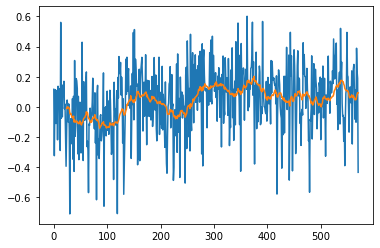

In [20]:
plt.figure()
x = range(len(rewards))
plt.plot(x, rewards)
plt.plot(x, rewards_df.rolling(25).mean())
plt.show()

In [18]:
env_data = test

all_envs = {}

full_env = OwnEnv(
    df=env_data,
    window_size=window_size,
    frame_bound=(window_size, len(env_data)),
    steps_per_episode=steps_per_episode,
    is_training=False,
    position_as_observation=True,
)
all_envs['Full test'] = full_env

#TODO: For the is_training=True we have to make that all executions are using same cases
step_env = OwnEnv(
    df=env_data,
    window_size=window_size,
    frame_bound=(window_size, len(env_data)),
    steps_per_episode=steps_per_episode,
    is_training=True,
    position_as_observation=True,
)
all_envs[f'Test step of {steps_per_episode}'] = step_env

large_step_env = OwnEnv(
    df=env_data,
    window_size=window_size,
    frame_bound=(window_size, len(env_data)),
    steps_per_episode=10 * steps_per_episode,
    is_training=True,
    position_as_observation=True,
)
all_envs[f'Test step of {10*steps_per_episode}'] = large_step_env

small_step_env = OwnEnv(
    df=env_data,
    window_size=window_size,
    frame_bound=(window_size, len(env_data)),
    steps_per_episode=int(0.1 * steps_per_episode),
    is_training=True,
    position_as_observation=True,
)
all_envs[f'Test step of {int(0.1 * steps_per_episode)}'] = small_step_env

In [16]:
def runAllTestEnv(all_envs, select_action_func, iterations=None, use_steps=False, use_observation=False, use_model=False, **kwargs):
    if type(all_envs) is list:
        all_envs = dict(zip([f'Env_{i}' for i in range(len(all_envs))], all_envs))

    if type(all_envs) is not dict:
        raise ValueError('all_envs should be dictionary of name and enviorment or a list of enviorments')
    else:
        for env_name, env in all_envs.items():
            print(f'Testing enviorment {env_name}:')
            runTestEnv(env, select_action_func, iterations=iterations, use_steps=use_steps, use_observation=use_observation, use_model=use_model, **kwargs)
            print('-'*50)

def runTestEnv(env, select_action_func, iterations=None, use_steps=False, use_observation=False, use_model=False, **kwargs):
    if iterations is None:
        if env.is_training:
            iterations = int((env.frame_bound[1] - env.frame_bound[0]) / env.steps_per_episode)
        else:
            iterations = 1
    
    total_rewards = []
    total_profits = [] 

    start_tick = env.window_size
    for i in range(iterations):
        observation = env.reset(start_tick=start_tick)
        if use_model:
            done = False
            recent_observations = []
            recent_terminals = []
        step = 0
        while True:
            if use_model:
                action = select_action_func(observation, recent_observations, recent_terminals, done, **kwargs)
            else:
                if use_observation:
                    if use_steps:
                        action = select_action_func(observation=observation, step=step, **kwargs)
                    else:
                        action = select_action_func(observation=observation, **kwargs)
                else:
                    if use_steps:
                        action = select_action_func(step=step, **kwargs)
                    else:
                        action = select_action_func(**kwargs)

            observation, reward, done, info = env.step(action)
            
            if done:
                start_tick = env._current_tick
                break

            step += 1

        total_rewards.append(info['total_reward'])
        total_profits.append(info['total_profit'])
    
    print(f'Total rewards: {np.mean(total_rewards):.2f} ± {np.std(total_rewards):.3f} (mean ± std. dev. of {iterations} iterations)')
    print(f'Total profits: {(np.mean(total_profits) - 1):.2%} ± {np.std(total_profits):.3%} (mean ± std. dev. of {iterations} iterations)')

    return total_rewards, total_profits

In [94]:
# Apply random policy on env
runAllTestEnv(all_envs, select_action_func=full_env.action_space.sample);

Testing enviorment Full test:
Total rewards: 5333.95 ± 0.000 (mean ± std. dev. of 1 iterations)
Total profits: 161.94% ± 0.000% (mean ± std. dev. of 1 iterations)
--------------------------------------------------
Testing enviorment Test step of 60:
Total rewards: 0.47 ± 47.647 (mean ± std. dev. of 4319 iterations)
Total profits: 0.02% ± 0.589% (mean ± std. dev. of 4319 iterations)
--------------------------------------------------
Testing enviorment Test step of 600:
Total rewards: 18.74 ± 127.498 (mean ± std. dev. of 431 iterations)
Total profits: 0.26% ± 1.596% (mean ± std. dev. of 431 iterations)
--------------------------------------------------
Testing enviorment Test step of 6:
Total rewards: 0.03 ± 10.810 (mean ± std. dev. of 43198 iterations)
Total profits: -0.00% ± 0.158% (mean ± std. dev. of 43198 iterations)
--------------------------------------------------


In [95]:
# Applying long term policy (buy at initial and do not sell) on env

def always_buy_func():
    return  Actions.Buy.value

runAllTestEnv(all_envs, select_action_func=always_buy_func);

Testing enviorment Full test:
Total rewards: 0.00 ± 0.000 (mean ± std. dev. of 1 iterations)
Total profits: 223.06% ± 0.000% (mean ± std. dev. of 1 iterations)
--------------------------------------------------
Testing enviorment Test step of 60:
Total rewards: 0.00 ± 0.000 (mean ± std. dev. of 4319 iterations)
Total profits: 0.03% ± 0.838% (mean ± std. dev. of 4319 iterations)
--------------------------------------------------
Testing enviorment Test step of 600:
Total rewards: 0.00 ± 0.000 (mean ± std. dev. of 431 iterations)
Total profits: 0.30% ± 2.241% (mean ± std. dev. of 431 iterations)
--------------------------------------------------
Testing enviorment Test step of 6:
Total rewards: 0.00 ± 0.000 (mean ± std. dev. of 43198 iterations)
Total profits: 0.00% ± 0.223% (mean ± std. dev. of 43198 iterations)
--------------------------------------------------


In [96]:
# Applying baseline policy on env

# Manual policy used as baseline

# RSI usually is between 0 and 100, here is normalized between -1 and 1
# The baseline strategy is buy at 30 and sell at 70 otherwise hold
def select_baseline_action(observation, rsi_thresh_buy=-0.6, rsi_thresh_sell=0.4, rsi_index=FEATURE_COLUMNS.index('Close_rsi')):
    # Use only last observation
    obs = observation[-1]

    position_value = int(obs[-1])
    rsi = obs[rsi_index]

    if position_value == Positions.Short.value and rsi <= rsi_thresh_buy:
        action = Actions.Buy.value
    elif position_value == Positions.Long.value and rsi >= rsi_thresh_sell:
        action = Actions.Sell.value
    else:
        # Hold
        # if it was in short remain in short because is selling
        # if it was in long remain in long because is buying
        action = position_value
    
    return action

runAllTestEnv(all_envs, select_action_func=select_baseline_action, use_observation=True, rsi_thresh_buy=-0.6, rsi_thresh_sell=0.4);

Testing enviorment Full test:
Total rewards: 11495.29 ± 0.000 (mean ± std. dev. of 1 iterations)
Total profits: 505.99% ± 0.000% (mean ± std. dev. of 1 iterations)
--------------------------------------------------
Testing enviorment Test step of 60:
Total rewards: 4.39 ± 38.377 (mean ± std. dev. of 4319 iterations)
Total profits: 0.04% ± 0.592% (mean ± std. dev. of 4319 iterations)
--------------------------------------------------
Testing enviorment Test step of 600:
Total rewards: 26.66 ± 107.598 (mean ± std. dev. of 431 iterations)
Total profits: 0.42% ± 1.445% (mean ± std. dev. of 431 iterations)
--------------------------------------------------
Testing enviorment Test step of 6:
Total rewards: 0.71 ± 7.860 (mean ± std. dev. of 43198 iterations)
Total profits: 0.00% ± 0.153% (mean ± std. dev. of 43198 iterations)
--------------------------------------------------


In [19]:
import numpy as np
from rl.memory import zeroed_observation

# Applying trained policy on env

def get_recent_state(current_observation, recent_observations, recent_terminals, window_length):
        """Return list of last observations

        # Argument
            current_observation (object): Last observation

        # Returns
            A list of the last observations
        """
        # This code is slightly complicated by the fact that subsequent observations might be
        # from different episodes. We ensure that an experience never spans multiple episodes.
        # This is probably not that important in practice but it seems cleaner.
        state = [current_observation]
        idx = len(recent_observations) - 1
        for offset in range(0, window_length - 1):
            current_idx = idx - offset
            current_terminal = recent_terminals[current_idx - 1] if current_idx - 1 >= 0 else False
            if current_idx < 0 or current_terminal:
                # The previously handled observation was terminal, don't add the current one.
                # Otherwise we would leak into a different episode.
                break
            state.insert(0, recent_observations[current_idx])
        while len(state) < window_length:
            state.insert(0, zeroed_observation(state[0]))
        return state

def select_model_action(observation, recent_observations, recent_terminals, done, window_size):
    obs = get_recent_state(observation, recent_observations, recent_terminals, window_size)
    obs = np.expand_dims(obs, axis=0)
    recent_observations.append(observation)
    recent_terminals.append(done)
    return np.argmax(model.predict(obs))

runAllTestEnv(all_envs, select_action_func=select_model_action, use_model=True, window_size=window_size, iterations=2);

Testing enviorment Full test:
Total rewards: -75.94 ± 0.000 (mean ± std. dev. of 2 iterations)
Total profits: 0.42% ± 0.000% (mean ± std. dev. of 2 iterations)
--------------------------------------------------
Testing enviorment Test step of 60:
Total rewards: -17.69 ± 10.690 (mean ± std. dev. of 2 iterations)
Total profits: -0.19% ± 0.112% (mean ± std. dev. of 2 iterations)
--------------------------------------------------
Testing enviorment Test step of 600:
Total rewards: -27.23 ± 16.975 (mean ± std. dev. of 2 iterations)
Total profits: -0.52% ± 0.420% (mean ± std. dev. of 2 iterations)
--------------------------------------------------
Testing enviorment Test step of 6:
Total rewards: 0.00 ± 0.000 (mean ± std. dev. of 2 iterations)
Total profits: 0.02% ± 0.006% (mean ± std. dev. of 2 iterations)
--------------------------------------------------


In [22]:
# After training is done, we save the final weights.
dqn.save_weights('dqn_{}_weights.h5f'.format('prices'), overwrite=True)